In [1]:
import sys
!{sys.executable} -m pip install -q torchaudio soundfile matplotlib audioseal

import typing as tp
import julius
import torch
import torchaudio
import urllib

### Load Audioseal models

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [3]:
from audioseal import AudioSeal

# model = AudioSeal.load_generator("audioseal_wm_16bits")
detector = AudioSeal.load_detector("./detector_base.pth", 16)

### Helper functions to load audio data, watermark audio, and get prediction scores for audio

In [4]:
# model = model.to(device)
detector = detector.to(device)

In [5]:
secret_message = torch.randint(0, 2, (1, 16), dtype=torch.int32)
secret_message = secret_message.to(device)
print(f"Secret message: {secret_message}")

# Function to load an audio file from its file path
def load_audio_file(
    file_path: str
) -> tp.Optional[tp.Tuple[torch.Tensor, int]]:
    try:
        wav, sample_rate = torchaudio.load(file_path)
        return wav, sample_rate
    except Exception as e:
        print(f"Error while loading audio: {e}")
        return None
    
# Function to generate a watermark for the audio and embed it into a new audio tensor
def generate_watermark_audio(
    tensor: torch.Tensor,
    sample_rate: int
) -> tp.Optional[torch.Tensor]:
    try:
        global model, device, secret_message
        audios = tensor.unsqueeze(0).to(device)
        watermarked_audio = model(audios, sample_rate=sample_rate, message=secret_message.to(device), alpha=1)
        return watermarked_audio

    
    except Exception as e:
        print(f"Error while watermarking audio: {e}")
        return None
    
# Function to get the confidence score that an audio tensor was watermarked by Audioseal
def detect_watermark_audio(
    tensor: torch.Tensor,
    sample_rate: int,
    message_threshold: float = 0.50
) -> tp.Optional[float]:
    try:
        global detector, device
        # In our analysis we are not concerned with the hidden/embedded message as of now
        result, _ = detector.detect_watermark(tensor, sample_rate=sample_rate, message_threshold=message_threshold)
        return float(result)
    except Exception as e:
        print(f"Error while detecting watermark: {e}")
        return None

Secret message: tensor([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1]], dtype=torch.int32)


In [6]:
WATERMARKED_RECORDINGS = 'cremad-recorded-wm'
RAW_RECORDINGS = 'cremad-recorded'

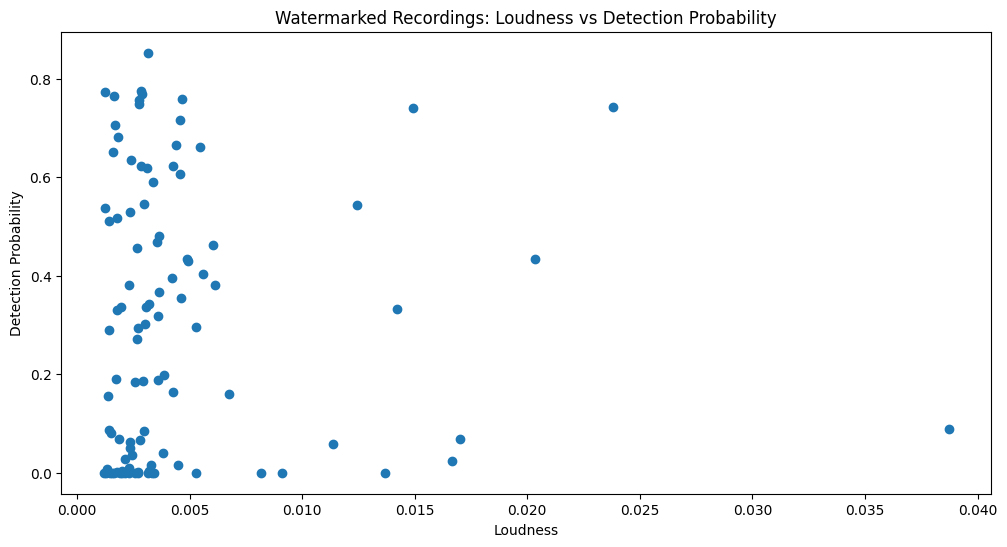

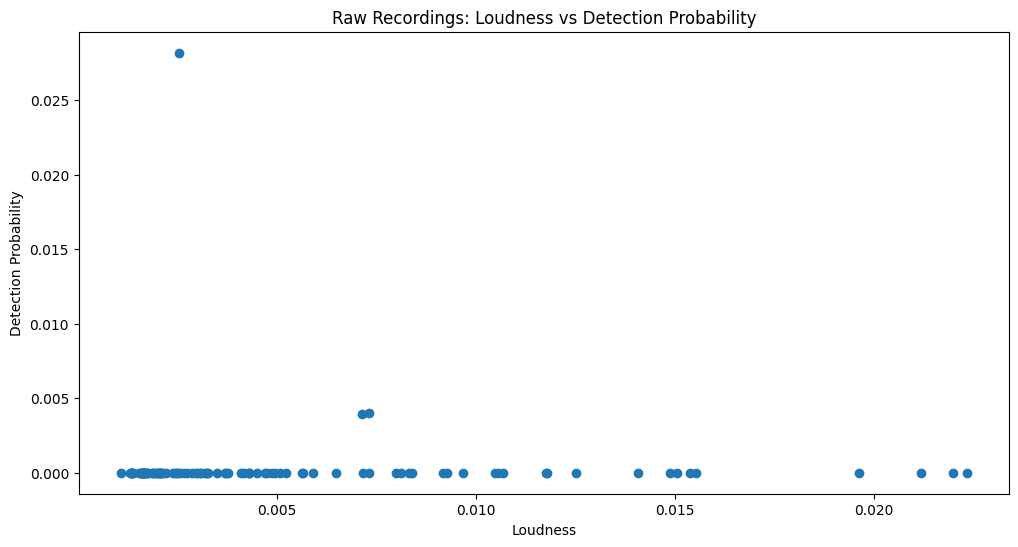

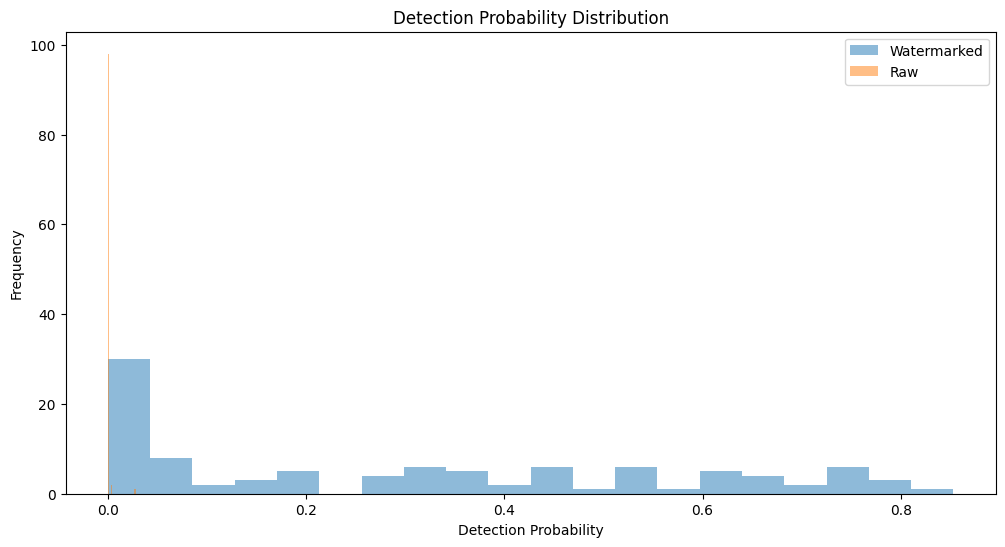

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torchaudio

# Function to load all audio files from a directory
def load_all_audio_files(directory: str) -> tp.List[tp.Tuple[str, torch.Tensor, int]]:
    audio_files = []
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        audio = load_audio_file(file_path)
        if audio is not None:
            audio_files.append((filename, *audio))
    return audio_files

# Load audio files
watermarked_audios = load_all_audio_files(WATERMARKED_RECORDINGS)
raw_audios = load_all_audio_files(RAW_RECORDINGS)

# Detect watermarks
def detect_watermarks(audios: tp.List[tp.Tuple[str, torch.Tensor, int]]) -> tp.List[tp.Tuple[str, float]]:
    results = []
    for filename, wav, sr in audios:
        wav = wav[1, :]
        score = detect_watermark_audio(wav.unsqueeze(0).unsqueeze(0), sr)
        if score is not None:
            results.append((filename, score))
    return results

watermarked_results = detect_watermarks(watermarked_audios)
raw_results = detect_watermarks(raw_audios)

# Analyze detection probability vs audio loudness
def calculate_loudness(tensor: torch.Tensor) -> float:
    return tensor.abs().mean().item()

def analyze_loudness_vs_detection(audios: tp.List[tp.Tuple[str, torch.Tensor, int]], results: tp.List[tp.Tuple[str, float]]) -> tp.List[tp.Tuple[str, float, float]]:
    analysis = []
    for (filename, wav, sr), (_, score) in zip(audios, results):
        loudness = calculate_loudness(wav)
        analysis.append((filename, loudness, score))
    return analysis

watermarked_analysis = analyze_loudness_vs_detection(watermarked_audios, watermarked_results)
raw_analysis = analyze_loudness_vs_detection(raw_audios, raw_results)

# Plot results
def plot_results(analysis: tp.List[tp.Tuple[str, float, float]], title: str):
    filenames, loudness, scores = zip(*analysis)
    plt.figure(figsize=(12, 6))
    plt.scatter(loudness, scores)
    plt.xlabel('Loudness')
    plt.ylabel('Detection Probability')
    plt.title(title)
    plt.show()

plot_results(watermarked_analysis, 'Watermarked Recordings: Loudness vs Detection Probability')
plot_results(raw_analysis, 'Raw Recordings: Loudness vs Detection Probability')

# Compare results
def compare_results(watermarked_analysis, raw_analysis):
    watermarked_scores = [score for _, _, score in watermarked_analysis]
    raw_scores = [score for _, _, score in raw_analysis]
    plt.figure(figsize=(12, 6))
    plt.hist(watermarked_scores, bins=20, alpha=0.5, label='Watermarked')
    plt.hist(raw_scores, bins=20, alpha=0.5, label='Raw')
    plt.xlabel('Detection Probability')
    plt.ylabel('Frequency')
    plt.title('Detection Probability Distribution')
    plt.legend()
    plt.show()

compare_results(watermarked_analysis, raw_analysis)


In [10]:
watermarked_analysis

[('1002_IEO_NEU_XX.wav', 0.0017870560986921191, 0.517662525177002),
 ('1002_IWL_HAP_XX.wav', 0.002660580910742283, 0.27142858505249023),
 ('1003_DFA_HAP_XX.wav', 0.0036415522918105125, 0.4814411401748657),
 ('1003_ITS_HAP_XX.wav', 0.0027546195778995752, 0.7569407224655151),
 ('1004_IOM_ANG_XX.wav', 0.0067469957284629345, 0.16036784648895264),
 ('1004_IWW_ANG_XX.wav', 0.0036425080616027117, 0.36753377318382263),
 ('1004_WSI_DIS_XX.wav', 0.00231315940618515, 0.0),
 ('1005_IEO_SAD_LO.wav', 0.001246812054887414, 0.7724812626838684),
 ('1006_IOM_HAP_XX.wav', 0.003584484104067087, 0.18820251524448395),
 ('1007_IOM_NEU_XX.wav', 0.0028137476183474064, 0.06670914590358734),
 ('1007_WSI_NEU_XX.wav', 0.0030012885108590126, 0.3030914068222046),
 ('1008_IEO_DIS_HI.wav', 0.006142611149698496, 0.38056492805480957),
 ('1008_IOM_SAD_XX.wav', 0.00385377649217844, 0.19806291162967682),
 ('1008_MTI_HAP_XX.wav', 0.004919730126857758, 0.43047189712524414),
 ('1009_TAI_DIS_XX.wav', 0.0024156731087714434, 0.6

In [8]:
np.array(watermarked_results)[:, 1].astype(np.float32).mean()

0.29874554

In [9]:
np.array(raw_results)[:, 1].astype(np.float32).mean()

0.00035811946